In [1]:
# Imports
import os
from pathlib import Path
import sys
from typing import * 
from time import perf_counter

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import tifffile as tf
import torch
from PIL import Image

from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data import transforms as T
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

import ROI_detection2.utils.train_utils as train_utils

from ubteacher.config import add_ubteacher_config
from ubteacher.engine.trainer import UBRCNNTeacherTrainer
from ubteacher.modeling.meta_arch.ts_ensemble import EnsembleTSModel
from ubteacher.modeling.meta_arch.rcnn import TwoStagePseudoLabGeneralizedRCNN
import ubteacher.utils.ROI_utils as ROI_utils

import cv2
import joblib
#import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pprint import pprint

plt.rcParams["figure.figsize"] = (25, 10)

In [2]:
def custom_visualizer(img_id, 
                      img, 
                      instances, 
                      color='r',
                      threshold = 0.7,
                      gt_instances = None, 
                      merged_bboxes = False, 
                      cat_map = None):
    """
    Custom visualizer for UBTeacher2 inference.
    """
    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(img)
    
    # Loop over instances and draw boxes
    if merged_bboxes:
        for i in range(len(instances)):
            if instances[i]['score'] > threshold:
                x1, y1, x2, y2 = instances[i]['bbox']
                w = x2 - x1
                h = y2 - y1
                rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)
    else:
        for i in range(len(instances)):
            if cat_map:
                cat = cat_map[str(instances[i].pred_classes.numpy()[0])]
            else:
                cat = instances[i]['category_id']
            score = float(instances[i]['score'])
            if score > threshold:
                x1, y1, x2, y2 = instances[i]['bbox']
                w = x2 - x1
                h = y2 - y1
                rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)
                #ax.text(x1, y1, cat, fontsize=9, color='r')
                #ax.text(x1, y1, str(round(instances[i]['score'], 2)), fontsize=11, color='g')
    # Loop over ground truth instances and draw boxes
    if gt_instances is not None:
        for i in range(len(gt_instances[img_id])):
            if cat_map:
                gt_cat = cat_map[str(gt_instances[img_id][i]['category_id'])]
            else:
                gt_cat = gt_instances[img_id][i]['category_id']
            box = gt_instances[img_id][i]['bbox']
            x1, y1, x2, y2 = box
            gt_rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor=color,facecolor='none')
            ax.add_patch(gt_rect)
            #ax.text(x1, y1, gt_cat, fontsize=9, color='g')
            try:
                gt_poly = gt_instances[img_id][i]['segmentation']
                gt_poly = np.array(gt_poly).reshape((int(len(gt_poly)/2), 2))
                ax.fill(gt_poly[:, 0], gt_poly[:, 1], alpha=0.5, color='g')
            except:
                print("No segmentation for ground truth annotation.")
                pass
    return fig, ax


In [3]:
image_id = "Case 27 F4"
src_dir = '/mnt/RSX/Datasets_pathology/GT_2023/LesionFinderMask/SRI_OSCC_lymph_unlabeled'
model_dir = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/tcga_mix_v2.8/'

In [4]:
image_file = os.path.join(src_dir, image_id + ".npy")
lf_model = os.path.join(model_dir, 'model_0129999.pth')
lf_config = os.path.join(model_dir, 'config.yaml')

img = np.load(image_file)
im = torch.from_numpy(img).permute(2, 0, 1)
inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]


In [5]:
# Load trained model from config and weights
cfg_tic = perf_counter()
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.PARENTDIR = ""
cfg.DETECTION_MODE = ""
cfg.DATASEED = ""
cfg.MODEL.ROI_BOX_HEAD.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_BOX_HEAD.NUM_CLASSES = 4
cfg.MODEL.RPN.NUM_CLASSES = 4
cfg.merge_from_file(lf_config)
cfg.MODEL.WEIGHTS = lf_model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5


student_model = UBRCNNTeacherTrainer.build_model(cfg)
teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
model = EnsembleTSModel(teacher_model, student_model)
model.eval()
used_model = model.modelTeacher

checkpointer = DetectionCheckpointer(model) 
checkpointer.load(cfg.MODEL.WEIGHTS)   

cfg_toc = perf_counter()
print(f"Loaded lf config in {cfg_toc-cfg_tic:0.4f} seconds")

Loaded lf config in 1.5413 seconds


In [6]:
with torch.no_grad():
    outputs = used_model(inputs)
    instances = outputs[0]["instances"].to("cpu")
    instance_dicts = []
    for i in range(len(instances)):
        instance_dicts.append({'category_id': instances[i].pred_classes.numpy()[0], 
                                'bbox': instances[i].pred_boxes.tensor.numpy()[0].tolist(),
                                'score': instances[i].scores.numpy()[0]})
        
print(instance_dicts)


/home/chao_lab/anaconda3/envs/AI_path/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'category_id': 0, 'bbox': [1524.0599365234375, 410.60552978515625, 1727.3280029296875, 510.7866516113281], 'score': 0.99477154}, {'category_id': 0, 'bbox': [179.4110107421875, 903.2183837890625, 360.3849182128906, 1153.676513671875], 'score': 0.99326384}, {'category_id': 0, 'bbox': [128.716552734375, 1163.2344970703125, 275.87847900390625, 1365.781494140625], 'score': 0.98933}, {'category_id': 0, 'bbox': [1843.6591796875, 657.9913330078125, 1951.1212158203125, 794.7891845703125], 'score': 0.98803025}, {'category_id': 0, 'bbox': [382.91845703125, 1020.176513671875, 609.2505493164062, 1233.845947265625], 'score': 0.9867291}, {'category_id': 0, 'bbox': [28.948562622070312, 942.40087890625, 230.44961547851562, 1164.114501953125], 'score': 0.98521614}, {'category_id': 0, 'bbox': [1592.3282470703125, 288.73297119140625, 1688.705810546875, 421.14056396484375], 'score': 0.9845031}, {'category_id': 0, 'bbox': [1522.186279296875, 287.60040283203125, 1736.3262939453125, 536.5308227539062], 'sco

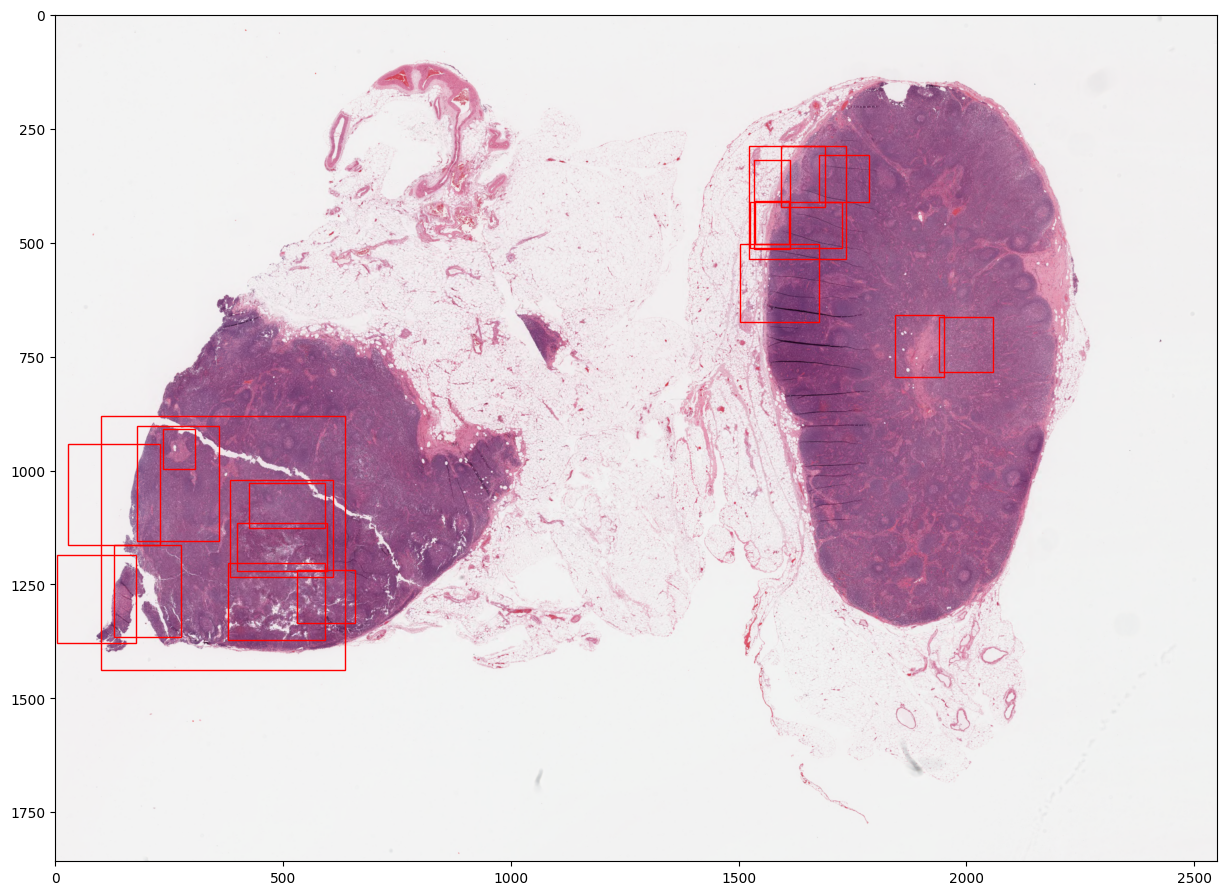

In [7]:
## Visualize
fig, ax = custom_visualizer(image_id, img, instance_dicts, merged_bboxes=False, threshold=0.9)